In [42]:
import os 

os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from datetime import datetime
import itertools
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import QuantileTransformer
from scipy.signal import detrend
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.regression.linear_model import OLS, WLS
import statsmodels.api as sm
from arch import arch_model
import numpy as np
from sklearn.covariance import LedoitWolf
from scipy import signal, fft
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300
OBS_THRESH = 120
HISTORY_START_DT = datetime(1984, 12, 31)
HISTORY_END_DT = datetime(2024, 12, 31)
MCAP_THRESH = .99
PRC_THRESH = 1
BT_START = datetime(2004, 12, 31)
BT_END = datetime(2024, 12, 31)
LOOKBACK = pd.DateOffset(years=20)
HL = 12

signals = ['b2m', 'c2p', 's2p', 'e2p', 'mom_12_1', 'mom_6_1', 'resid_mom']#, 'strev']
signal_grouping = {
    "Value": ['b2m', 'c2p', 's2p', 'e2p'],
    "Momentum/Reversion": ['mom_12_1', 'mom_6_1', 'resid_mom', 'strev'],
}

In [2]:
def market_coverage(market_cap, thresh):
    """Selects stocks based on market cap threshold."""
    tot_mcap = market_cap.sum()
    target_mcap = tot_mcap * thresh
    pick = market_cap.sort_values(ascending=False).cumsum().loc[lambda x: x <= target_mcap].index
    size_flag = pd.Series(False, index=market_cap.index, dtype=bool)
    size_flag[pick] = True
    return size_flag


def cleanup_ts(original_ts, thresh):
    segment_mapping = (original_ts.notna() != original_ts.notna().shift(1)).cumsum()
    segment_mapping_notna = segment_mapping[original_ts.notna()]
    continuous_segment_id = segment_mapping_notna[original_ts.notna()].groupby(segment_mapping_notna[original_ts.notna()]).count().idxmax()
    continuous_ts = original_ts[segment_mapping == continuous_segment_id].reindex(original_ts.index)
    if continuous_ts.count() >= thresh:
        return continuous_ts
    else:
        return pd.Series(index=original_ts.index)

In [3]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
raw_signals = raw_signals.loc[HISTORY_START_DT:HISTORY_END_DT]
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")
mcap = crsp['shrout'].mul(crsp['prc'].abs()).astype(float)
xs_rt = crsp["excess_ret"].astype(float)
fwd_rt = xs_rt.unstack().shift(-1)
micro_flag = mcap.groupby("date", group_keys=False).apply(market_coverage, .99).reindex(raw_signals.index).fillna(False)  # Micro-cap stocks

In [4]:
# # Raw signals exluding micro-caps
# X = raw_signals.mask(micro_flag).dropna(how='all', axis=0)

# # Cross-sectional standardization
# collect_signals = {}

# for sgnl in tqdm(signals):
#     collect_std = {}
#     X_f = X[sgnl].unstack()
#     for dt in X_f.index:
#         x_t = X_f.loc[dt].dropna()
#         qt = QuantileTransformer(output_distribution='normal')
#         qt.fit(x_t.to_frame())
#         z_t = pd.Series(qt.transform(x_t.to_frame()).flatten(), index=x_t.index)
#         collect_std[dt] = z_t

#     collect_signals[sgnl] = pd.DataFrame.from_dict(collect_std, orient='index').sort_index().stack()
    
# Z = pd.DataFrame.from_dict(collect_signals)
# Z.index.names = ["date", "permno"]

# # Z.to_pickle(r"C:\Users\franc\bin\signaltk\data\clean_signals.pkl")

Z = pd.read_pickle(r"C:\Users\franc\bin\signaltk\data\clean_signals.pkl")

## Baseline 

In [5]:
obs_dts = Z.sort_index().index.get_level_values("date").unique()
sgnl_0 = Z.mean(axis=1)
sgnl_0 = sgnl_0[[x for x in obs_dts if BT_START <= x < BT_END]]

In [6]:
sign_0 = sgnl_0.apply(np.sign)
pos_sgnal = sgnl_0[sgnl_0 > 0]
neg_sgnal = sgnl_0[sgnl_0 < 0]
w_pos_0 = pos_sgnal.div(pos_sgnal.groupby("date").sum())
w_neg_0 = neg_sgnal.div(neg_sgnal.groupby("date").sum().abs())
w_0 = pd.concat([w_pos_0, w_neg_0], axis=0)

<Axes: xlabel='date'>

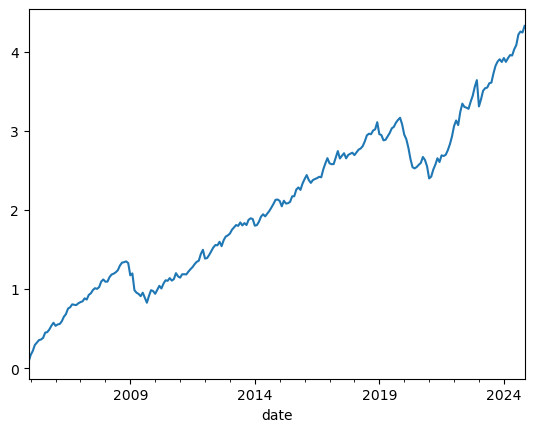

In [7]:
bt_rt_0 = w_0.groupby("permno").shift(1).mul(xs_rt).dropna().groupby("date").sum()
bt_px_0 = bt_rt_0.add(1).cumprod()
bt_px_0.apply(np.log).plot()

## Attenuator

In [43]:
obs_dts = Z.sort_index().index.get_level_values("date").unique()

collect_lmb = {}
collect_resid = {}
for dt in obs_dts[:-1]:
    X_t = Z.xs(dt)
    r_t = fwd_rt.xs(dt).dropna()
    cmn_idx = pd.concat([X_t, r_t], axis=1).dropna().index

    mdl = WLS(
        endog=r_t.reindex(cmn_idx), 
        exog=sm.add_constant(X_t.reindex(cmn_idx)), 
        weights=mcap.xs(dt).reindex(cmn_idx) / mcap.xs(dt).reindex(cmn_idx).sum()
    ).fit()
    collect_lmb[dt] = mdl.params.drop("const")
    collect_resid[dt] = mdl.wresid

lmb_t = pd.DataFrame.from_dict(collect_lmb, orient='index').sort_index()
lmb_t.index.name = "date"

residuals = pd.DataFrame.from_dict(collect_resid, orient='index').sort_index()
residuals.index.name = "date"

# TODO: Replace these estimates by VAR-MGARCH
mu_t = lmb_t.ewm(halflife=HL).mean()
sigma_t = lmb_t.ewm(halflife=HL).cov()
e_t = residuals.var(axis=1).ewm(halflife=HL).mean()

"""
From Adaptive beamforming for maximum SINR in the presence of correlated interferences:
The complex envelope sk(t) can be
decomposed into two components, the one fully correlated with the
desired signal and the other uncorrelated [2,7,18]

The correlated part should be the covariance of the loadings while the uncorrelated part should be the residuals. This should be a diagonal
matrix of idio variances 
"""

# import mgarch
# vol = mgarch.mgarch()
# vol.fit(lmb_t)
# pd.DataFrame(vol.predict(1)["cov"])

# pd.DataFrame(LedoitWolf().fit(lmb_t).covariance_)

In [49]:
lmb_t.expanding(axis=0)

C:\Users\franc\AppData\Local\Temp\ipykernel_19428\2577587685.py:1: FutureWarning: The 'axis' keyword in DataFrame.expanding is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  lmb_t.expanding(axis=0)


Expanding [min_periods=1,axis=0,method=single]

In [52]:
lmb_t.expanding(method="table").apply(lambda x: LedoitWolf().fit(x).covariance_)
# lmb_t.expanding(method="table").apply(lambda x: print(x))

ValueError: Data must be 1-dimensional, got ndarray of shape (480, 7) instead

In [44]:
pd.DataFrame(LedoitWolf().fit(lmb_t).covariance_)

,0,1,2,3,4,5,6
0,0.000207,-0.000017,-0.000015,0.000092,0.000093,0.000019,-0.000064
1,-0.000017,0.000630,-0.000070,-0.000559,-0.000019,0.000027,0.000011
2,-0.000015,-0.000070,0.000306,0.000064,-0.000089,-0.000034,0.000057
3,0.000092,-0.000559,0.000064,0.000827,0.000110,-0.000017,-0.000076
4,0.000093,-0.000019,-0.000089,0.000110,0.000958,0.000013,-0.000555
5,0.000019,0.000027,-0.000034,-0.000017,0.000013,0.000297,-0.000090
6,-0.000064,0.000011,0.000057,-0.000076,-0.000555,-0.000090,0.000502


In [56]:
LedoitWolf().fit(lmb_t.loc[:dt]).covariance_

array([[ 2.07231652e-04, -1.74405030e-05, -1.45552489e-05,
         9.23411149e-05,  9.34845996e-05,  1.94409039e-05,
        -6.38437445e-05],
       [-1.74405030e-05,  6.29675809e-04, -7.00180975e-05,
        -5.58632296e-04, -1.90156803e-05,  2.65559752e-05,
         1.05497842e-05],
       [-1.45552489e-05, -7.00180975e-05,  3.06052132e-04,
         6.38574971e-05, -8.92874195e-05, -3.38103157e-05,
         5.74080073e-05],
       [ 9.23411149e-05, -5.58632296e-04,  6.38574971e-05,
         8.26898751e-04,  1.09501206e-04, -1.72993899e-05,
        -7.59153482e-05],
       [ 9.34845996e-05, -1.90156803e-05, -8.92874195e-05,
         1.09501206e-04,  9.58210508e-04,  1.29579450e-05,
        -5.55425657e-04],
       [ 1.94409039e-05,  2.65559752e-05, -3.38103157e-05,
        -1.72993899e-05,  1.29579450e-05,  2.97142686e-04,
        -9.01171379e-05],
       [-6.38437445e-05,  1.05497842e-05,  5.74080073e-05,
        -7.59153482e-05, -5.55425657e-04, -9.01171379e-05,
         5.0197828

In [57]:
collect_sgnl_1 = []
for dt in [x for x in obs_dts if BT_START <= x < BT_END]:
    # V = sigma_t.xs(dt).values + np.eye(sigma_t.shape[1]) * e_t.xs(dt)
    V = LedoitWolf().fit(lmb_t.loc[:dt]).covariance_ + np.eye(sigma_t.shape[1]) * e_t.xs(dt)
    x_t = mu_t.xs(dt).values.reshape(-1, 1)
    # x_t = np.ones((V.shape[0], 1))

    o_t = (np.linalg.inv(V) @ x_t).flatten()
    o_t = pd.Series(o_t / o_t.sum(), index=sigma_t.columns)

    s_t = Z.xs(dt).mul(o_t, axis=1).sum(axis=1)
    s_t.index = pd.MultiIndex.from_product([[dt], s_t.index], names=["date", "permno"])
    collect_sgnl_1.append(s_t)
sgnl_1 = pd.concat(collect_sgnl_1, axis=0).replace(0, np.nan).dropna()

In [58]:
sign_1 = sgnl_1.apply(np.sign)
pos_sgnal = sgnl_1[sign_1 > 0]
neg_sgnal = sgnl_1[sign_1 < 0]
w_pos_1 = pos_sgnal.div(pos_sgnal.groupby("date").sum())
w_neg_1 = neg_sgnal.div(neg_sgnal.groupby("date").sum().abs())
w_1 = pd.concat([w_pos_1, w_neg_1], axis=0)

<Axes: xlabel='date'>

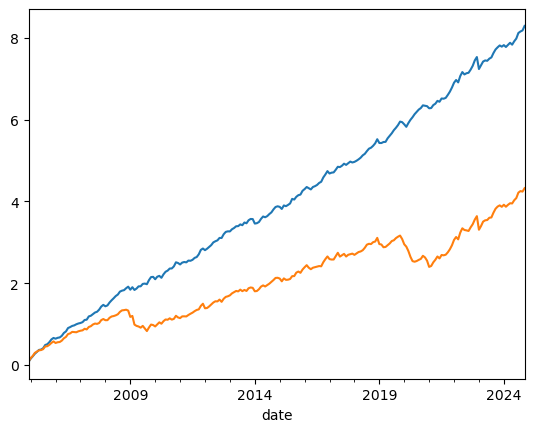

In [59]:
bt_rt_1 = w_1.groupby("permno").shift(1).mul(xs_rt).dropna().groupby("date").sum()
bt_px_1 = bt_rt_1.add(1).cumprod()
bt_px_1.apply(np.log).plot()
bt_px_0.apply(np.log).plot()

<Axes: xlabel='date'>

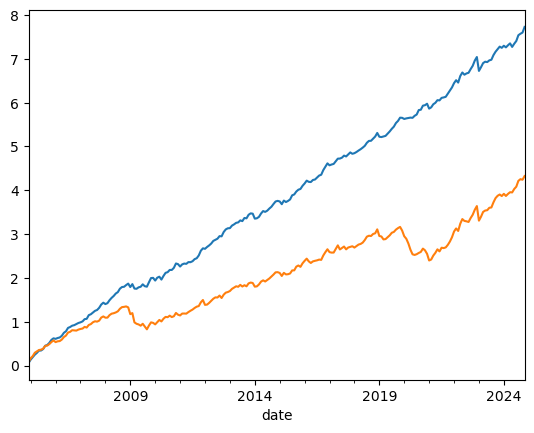

In [41]:
bt_rt_1 = w_1.groupby("permno").shift(1).mul(xs_rt).dropna().groupby("date").sum()
bt_px_1 = bt_rt_1.add(1).cumprod()
bt_px_1.apply(np.log).plot()
bt_px_0.apply(np.log).plot()

In [12]:
Z.xs(dt).mul(omega_t, axis=1).sum(axis=1)

NameError: name 'omega_t' is not defined

https://medium.com/@itberrios6/introduction-to-beamforming-part-3-e7158f297784

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

DTW Distance: 0.5


<Axes: xlabel='Index', ylabel='Query value'>

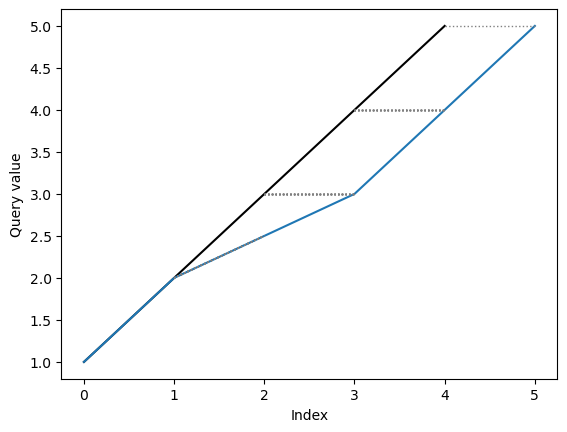

In [ ]:
import numpy as np
from dtw import dtw, dtwPlotTwoWay

# Example time series
s1 = np.array([1, 2, 3, 4, 5])
s2 = np.array([1, 2, 2.5, 3, 4, 5])

# Compute DTW alignment
alignment = dtw(s1, s2, keep_internals=True)

# Print the distance
print(f"DTW Distance: {alignment.distance}")

# Plot the alignment (optional)
dtwPlotTwoWay(alignment)

# The capon beamforming (MVDR) does not have much to do with the signal power, but everything to do with the covariance and the sterring vector

In [ ]:
np.linalg.inv(sigma_t.xs(dt)) @ mu_t.xs(dt).values.reshape(-1, 1)


array([[-43.61984042],
       [ 70.93969683],
       [ -0.29833432],
       [ 69.47443316],
       [ -9.58670727],
       [-10.12398684],
       [ 17.55399061]])

## Phasing (Steering vector)

In [ ]:
rebalance_dts = [x for x in Z.index.get_level_values("date").unique() if x >= BT_START and x <= BT_END]

In [ ]:
rebalance_dts = [x for x in Z.index.get_level_values("date").unique() if x >= BT_START and x <= BT_END]

for dt in rebalance_dts:
    Z_t = Z.loc[:dt]
    
    # TODO: Estimate the risk premium using this data
    
    # Signal filtering
    n_obs = Z_t.groupby("permno").count()
    is_active = Z_t.xs(dt).notnull().all(axis=1)
    complete_obs = (n_obs >= OBS_THRESH).all(axis=1).reindex(is_active.index)
    is_investable = is_active & complete_obs
    investable_ids = is_investable[is_investable].index

    # TODO: Insert here the fitering below

    # TODO: Using the last 10 years of data, there has to be a risk model estimation step here
    # TODO: I NEED TO DRAW THIS ON THE TABLET TO ESTIMATE THE ATTENUATOR, BEFORE GOING INTO STOCK LEVEL
    
    # Z_t = Z_t.loc[pd.IndexSlice[:, investable_ids], :]

    


In [ ]:
collector_ = {}
for sgnl, vals in Z_t.items():
    X = vals.dropna().unstack()

    sec_id = 15203

    x_t = X[sec_id].dropna()
    z_t = detrend(x_t)
    c_t = x_t.values - z_t
    scale = np.std(z_t, ddof=0)
    z_t = np.divide(z_t, scale)
    n = len(x_t)
    fhat = fft.rfft(z_t, n)
    f, Pxx_den = signal.periodogram(z_t, 10e3, scaling='density')

    # Clustering the frequency domain representation
    cat = MiniBatchKMeans(n_clusters=3, n_init="auto", init="k-means++", random_state=12345).fit(Pxx_den.reshape(-1, 1))
    filt_val = cat.cluster_centers_.flatten().argmax()
    filt_flags = cat.labels_ == filt_val
    filt_fhat = np.where(filt_flags, fhat, 0)
    s_t = fft.irfft(filt_fhat, n=n)
    s_t = np.multiply(s_t, scale) + c_t

    collector_[sgnl] = pd.Series(s_t, index=x_t.index)

In [ ]:
df = pd.DataFrame.from_dict(collector_)

<Axes: xlabel='date'>

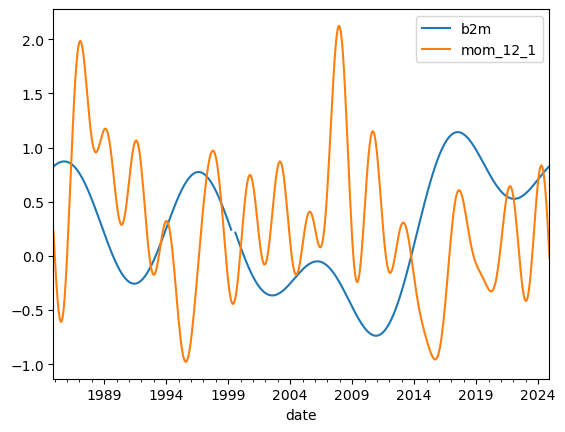

In [ ]:
df[["b2m", "mom_12_1"]].plot()

In [ ]:
# Example time series
s1 = df["b2m"].values
s2 = df["mom_12_1"].values

# Compute DTW alignment
alignment = dtw(s1, s2, keep_internals=True)

# Print the distance
print(f"DTW Distance: {alignment.distance}")

# Plot the alignment (optional)
dtwPlotTwoWay(alignment)

ValueError: No warping path found compatible with the local constraints

In [ ]:
collect_filt_signals = {}
for sgnl, vals in Z_t.items():
    X = vals.dropna().unstack()
    collect_s = {}  # Time series domain
    for sec_id in tqdm(X.columns, desc=sgnl):
        x_t = X[sec_id].dropna()
        z_t = detrend(x_t)
        c_t = x_t.values - z_t
        scale = np.std(z_t, ddof=0)
        z_t = np.divide(z_t, scale)
        n = len(x_t)
        fhat = fft.rfft(z_t, n)
        f, Pxx_den = signal.periodogram(z_t, 10e3, scaling='density')

        # Clustering the frequency domain representation
        cat = MiniBatchKMeans(n_clusters=3, n_init="auto", init="k-means++", random_state=12345).fit(Pxx_den.reshape(-1, 1))
        filt_val = cat.cluster_centers_.flatten().argmax()
        filt_flags = cat.labels_ == filt_val
        filt_fhat = np.where(filt_flags, fhat, 0)
        s_t = fft.irfft(filt_fhat, n=n)
        s_t = np.multiply(s_t, scale) + c_t

        collect_s[sec_id] = pd.Series(s_t, index=x_t.index)
    collect_filt_signals[sgnl] = pd.DataFrame.from_dict(collect_s).stack()
F_t = pd.DataFrame.from_dict(collect_filt_signals)
F_t.index.names = ["date", "permno"]

NameError: name 'Z_t' is not defined

In [ ]:
F_t